In this practical session, you will implement different strategies to build a recommender system.

# Dataset



We will use The Movie Dataset, available on Kaggle.
It contains metadata for all 45,000 movies listed in the [Full MovieLens Dataset](https://grouplens.org/datasets/movielens/). The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.
You will need [Kaggle](https://www.kaggle.com/) account to download the data.  You should already have one since the DEFI IA is hosted on Kaggle this year. If you don't, it is time to create your account (and to start participating to the DEFI ;-) )
Once you are logged into Kaggle, go to your account and scroll down to the API section to generate a new token.
![](https://drive.google.com/uc?export=view&id=1YcSTHD_FGrwDKaaLk6T9Gsdte8TKuPCt)
Now install the kaggle library to download the dataset directly from the notebook.



In [2]:
!pip install kaggle

Run the next cell to upload your token.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


We will start by working with the metadata dataset.
It contains information about the movies like their title, description, genres, or even their average IMDB ratings.

In [ ]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f movies_metadata.csv
!kaggle datasets download "rounakbanik/the-movies-dataset" -f ratings.csv
!unzip movies_metadata.csv.zip
!unzip ratings.csv.zip

 41% 5.00M/12.2M [00:00<00:00, 42.2MB/s]
100% 12.2M/12.2M [00:00<00:00, 84.2MB/s]
 99% 169M/170M [00:02<00:00, 110MB/s]
100% 170M/170M [00:02<00:00, 80.5MB/s]
Archive:  movies_metadata.csv.zip
  inflating: movies_metadata.csv     
Archive:  ratings.csv.zip
  inflating: ratings.csv             


Use pandas to explore the `movies_metadata.csv` dataset.

> Indented block



In [ ]:
import pandas as pd
metadata = pd.read_csv('movies_metadata.csv')
metadata.dropna(subset=['title'], inplace=True)
metadata['id'] = pd.to_numeric(metadata['id'])
metadata['genres'] = metadata['genres'].apply(lambda x: [i['name'] for i in eval(x)])
metadata = metadata[['id', 'title', 'genres', 'release_date', 'vote_average', 'vote_count']]
metadata.head(5)

<ipython-input-55-8e2a9fc35ff1>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('movies_metadata.csv')


id                        title                        genres  \
0    862                    Toy Story   [Animation, Comedy, Family]   
1   8844                      Jumanji  [Adventure, Fantasy, Family]   
2  15602             Grumpier Old Men             [Romance, Comedy]   
3  31357            Waiting to Exhale      [Comedy, Drama, Romance]   
4  11862  Father of the Bride Part II                      [Comedy]   

  release_date  vote_average  vote_count  
0   1995-10-30           7.7      5415.0  
1   1995-12-15           6.9      2413.0  
2   1995-12-22           6.5        92.0  
3   1995-12-22           6.1        34.0  
4   1995-02-10           5.7       173.0

In [ ]:
metadata.shape

(45460, 6)

Using the release date, create a new column called `year` and use seaborn to plot the number of movies per year.

Text(0.5, 1.0, 'Number of movies by year')

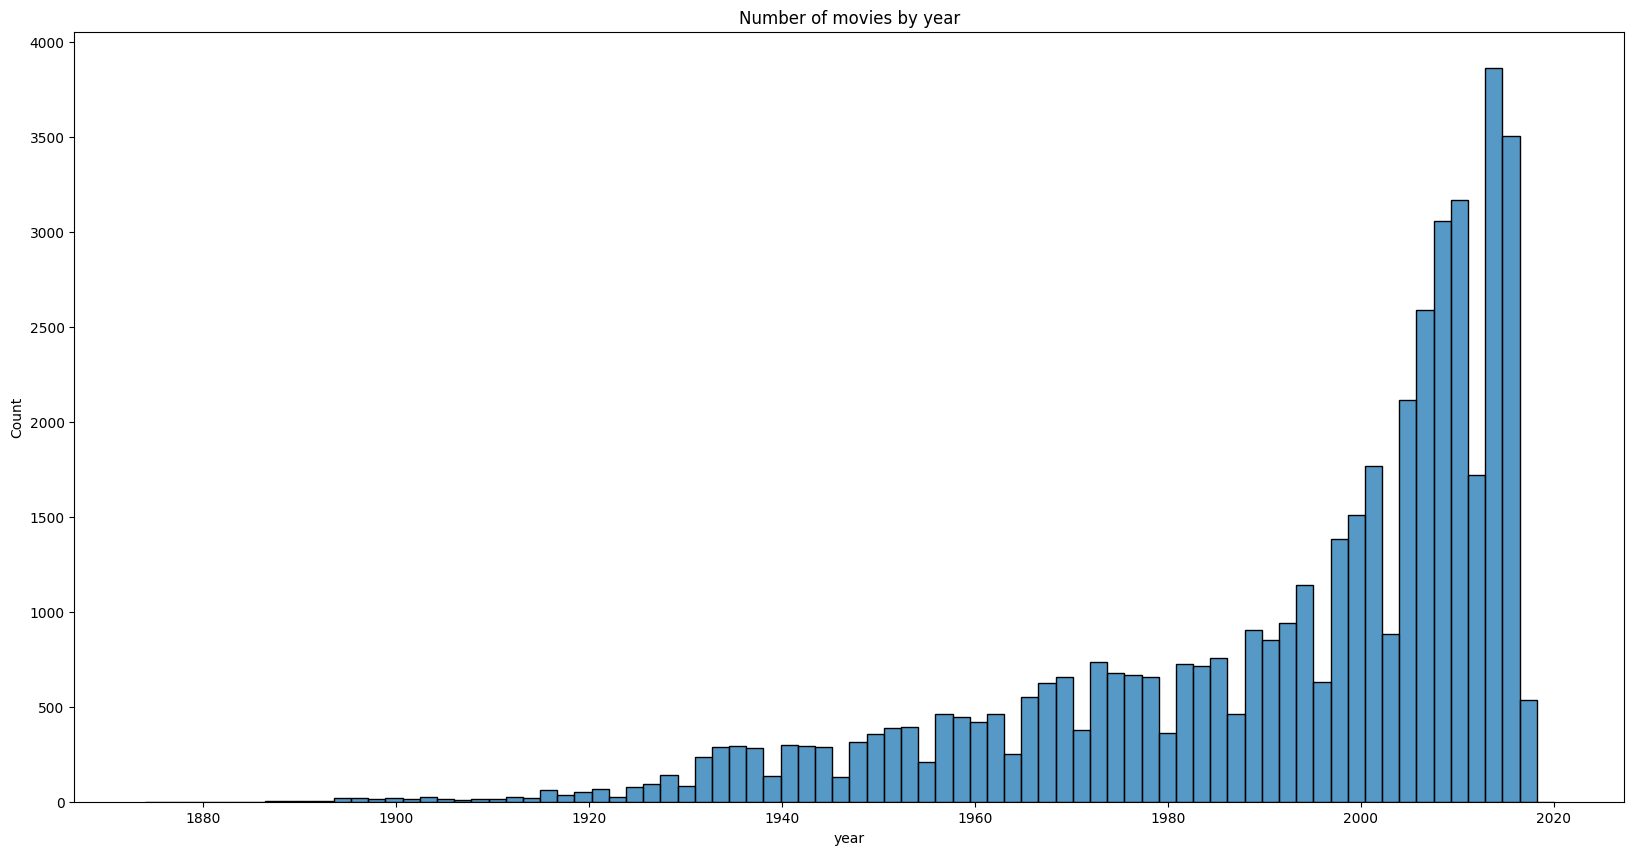

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metadata['year'] = pd.DatetimeIndex(metadata['release_date']).year

plt.figure(figsize=(20,10))
sns.histplot(data=metadata, x="year")
plt.title('Number of movies by year')

# Recommendation by popularity

You may have guessed that the average score is only reliable when it is averaged on a sufficient number of votes.
Use seaborn ```histplot``` method to plot the histogram of the number of votes.
For better readability you may first do this plot for the movies with less than 100 votes and then do another ones for the remaining ones.

In [ ]:
metadata.sort_values('vote_average', ascending=False).head()

id                                            title  \
21642  320849  Ice Age Columbus: Who Were the First Americans?   
15710   96451        If God Is Willing and da Creek Don't Rise   
22396   72123                                   Meat the Truth   
22395  230864            Marvin Hamlisch: What He Did For Love   
35343  140595                       Elaine Stritch: At Liberty   

                                       genres release_date  vote_average  \
21642                           [Documentary]   2005-01-01          10.0   
15710                           [Documentary]   2010-08-23          10.0   
22396                           [Documentary]   2008-10-03          10.0   
22395                           [Documentary]   2013-10-12          10.0   
35343  [Comedy, Documentary, Music, TV Movie]   2002-01-01          10.0   

       vote_count    year  
21642         1.0  2005.0  
15710         1.0  2010.0  
22396         1.0  2008.0  
22395         1.0  2013.0  
35343         1.0  2002.0

You may have guessed that the average score is only reliable when it is averaged on a sufficient number of votes.
Use seaborn ```histplot``` method to plot the histogram of the number of votes.
For better readability you may first do this plot for the movies with less than 100 votes and then do another one for the remaining ones.

Text(0.5, 1.0, 'Vote count')

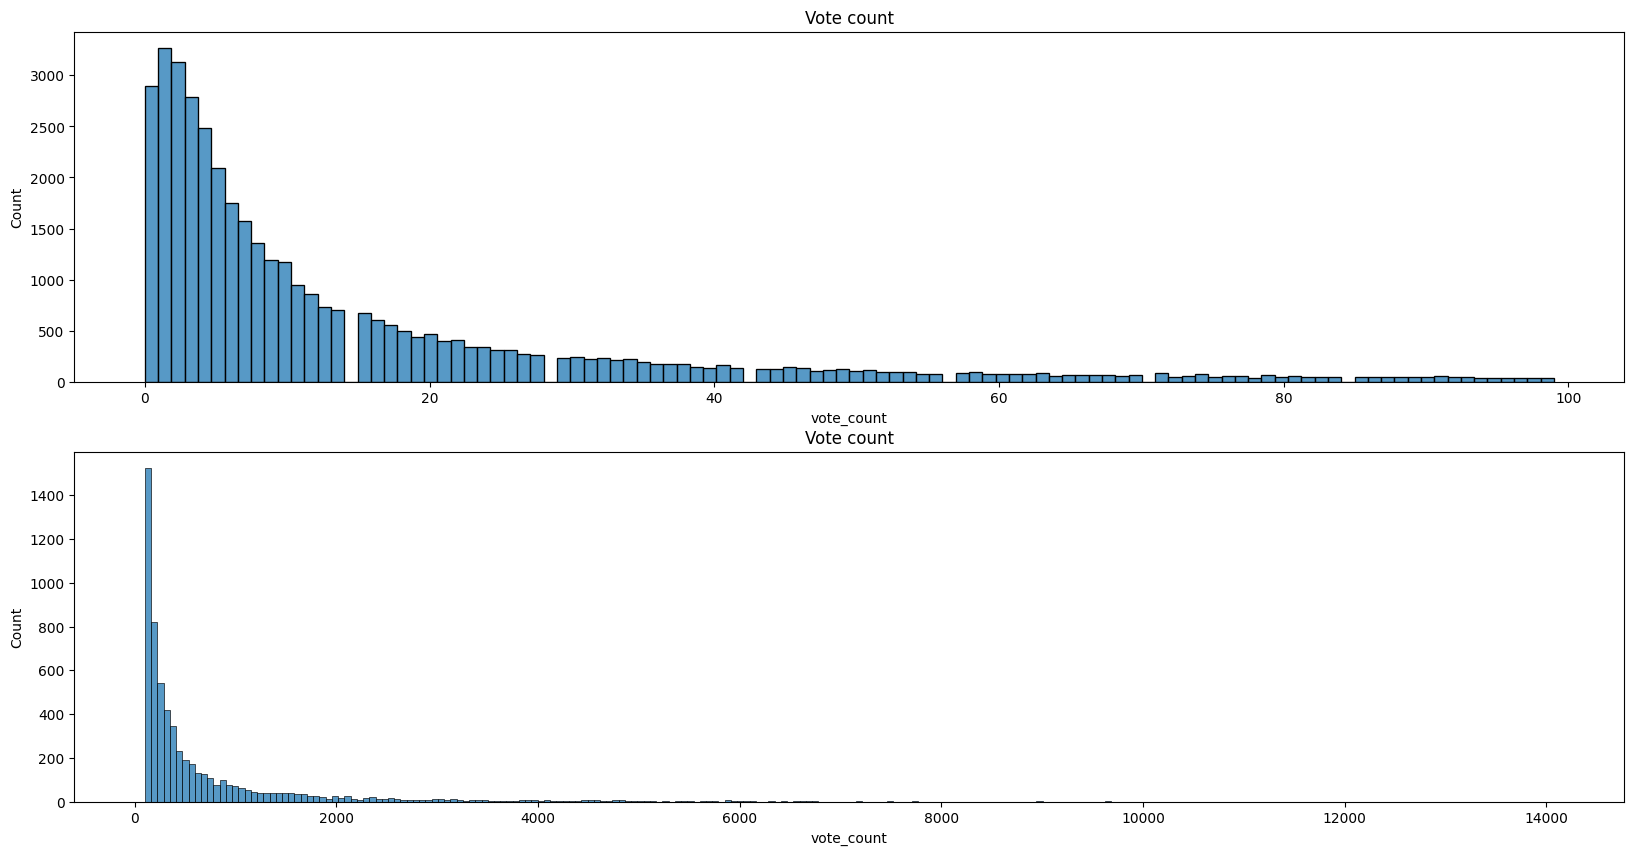

In [ ]:
metadata['year'] = pd.DatetimeIndex(metadata['release_date']).year
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(data=metadata[metadata['vote_count']< 100], x="vote_count")
plt.title('Vote count')
plt.subplot(2,1,2)
sns.histplot(data=metadata[metadata['vote_count']> 100], x="vote_count")
plt.title('Vote count')

Try to visualize the best movies according to the average vote for movies that have at least 1000 votes.
You should now know some of these movies.


In [ ]:
best_movies = metadata[metadata['vote_count'] > 1000].sort_values('vote_average', ascending=False)
best_movies[['title', 'vote_average']].head(15)

title  vote_average
314           The Shawshank Redemption           8.5
40251                       Your Name.           8.5
834                      The Godfather           8.5
1152   One Flew Over the Cuckoo's Nest           8.3
1176                            Psycho           8.3
1178            The Godfather: Part II           8.3
1184       Once Upon a Time in America           8.3
522                   Schindler's List           8.3
5481                     Spirited Away           8.3
292                       Pulp Fiction           8.3
23673                         Whiplash           8.3
12481                  The Dark Knight           8.3
2843                        Fight Club           8.3
2211                 Life Is Beautiful           8.3
5878                       City of God           8.2

## Best movies by IMDb score
IMDb (an acronym for Internet Movie Database) is an online database of information related to films, television programs, home videos, video games, and streaming content online.
It might be considered as one of the most exhaustive databases on movies.
In addition, IMDb maintains a ranking of movies according to people's votes. To do so, it computes a score based on the average rating and the number of votes.
The formula they are using is described [here](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#)
![](https://drive.google.com/uc?export=view&id=12J_uJ86eOimr8Y0LHTGSMmUgkBnZu9cO)
Use this formula to compute the IMDb score for all movies and visualize the ones with the best scores. (You may use a smaller value for m, 500 for example)


In [ ]:
m = 500
c = metadata.vote_average.mean()

def imdb_score(x):
    v = x['vote_count']
    r= x['vote_average']
    return (v/(v+m) * r) + (m/(m+v) * c)

metadata['imdb_score'] = metadata.apply(imdb_score, axis=1)
best_movies = metadata.sort_values('imdb_score', ascending=False)
best_movies[['title', 'imdb_score']].head(15)

title  imdb_score
314                         The Shawshank Redemption    8.337334
834                                    The Godfather    8.279139
12481                                The Dark Knight    8.194988
2843                                      Fight Club    8.168255
292                                     Pulp Fiction    8.153774
351                                     Forrest Gump    8.050712
522                                 Schindler's List    8.028344
23673                                       Whiplash    8.025001
15480                                      Inception    8.014861
1154                         The Empire Strikes Back    8.001339
5481                                   Spirited Away    7.999889
22879                                   Interstellar    7.993823
18465                               The Intouchables    7.981574
2211                               Life Is Beautiful    7.976347
7000   The Lord of the Rings: The Return of the King    7.957793

What were the best movies in your birth year?

In [ ]:
best_movies = metadata[metadata.year == 1987].sort_values('imdb_score', ascending=False)
best_movies[['title', 'imdb_score']].head(15)

title  imdb_score
1179               Full Metal Jacket    7.531374
1155              The Princess Bride    7.108971
2085                The Untouchables    7.084981
3406                        Predator    6.980146
1216                    Evil Dead II    6.753257
2869                         RoboCop    6.728437
1056                   Dirty Dancing    6.704010
1891                   Lethal Weapon    6.629943
3328           Good Morning, Vietnam    6.460193
3977               Empire of the Sun    6.451467
1345                 Raising Arizona    6.445328
3877  Planes, Trains and Automobiles    6.405627
1851                The Last Emperor    6.366478
3882                     Wall Street    6.346361
2916                      Spaceballs    6.320157

The following code will create a data frame containing one-hot encoding of the movie's genre.
Use it to recommend the best movies according to the genre and the IMDB score (for example the best Horror movies)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_df = pd.DataFrame(mlb.fit_transform(metadata['genres'].fillna('[]')),columns=mlb.classes_, index=metadata.index)
metadata = pd.concat([metadata.drop(columns=['genres']), genre_df], axis=1)
metadata.head()

id                        title release_date  vote_average  vote_count  \
0    862                    Toy Story   1995-10-30           7.7      5415.0   
1   8844                      Jumanji   1995-12-15           6.9      2413.0   
2  15602             Grumpier Old Men   1995-12-22           6.5        92.0   
3  31357            Waiting to Exhale   1995-12-22           6.1        34.0   
4  11862  Father of the Bride Part II   1995-02-10           5.7       173.0   

     year  imdb_score  Action  Adventure  Animation  ...  History  Horror  \
0  1995.0    7.524024       0          0          1  ...        0       0   
1  1995.0    6.679988       0          1          0  ...        0       0   
2  1995.0    5.755243       0          0          0  ...        0       0   
3  1995.0    5.648883       0          0          0  ...        0       0   
4  1995.0    5.639233       0          0          0  ...        0       0   

   Music  Mystery  Romance  Science Fiction  TV Movie  Thriller  War  Western  
0      0        0        0                0         0         0    0        0  
1      0        0        0                0         0         0    0        0  
2      0        0        1                0         0         0    0        0  
3      0        0        1                0         0         0    0        0  
4      0        0        0                0         0         0    0        0  

[5 rows x 27 columns]

In [ ]:
best_movies = metadata[metadata['Comedy'] == 1].sort_values('imdb_score', ascending=False)
best_movies[['title', 'imdb_score']].head(15)

title  imdb_score
351                   Forrest Gump    8.050712
18465             The Intouchables    7.981574
2211             Life Is Beautiful    7.976347
1225            Back to the Future    7.823283
22841     The Grand Budapest Hotel    7.768488
22131      The Wolf of Wall Street    7.743025
30315                   Inside Out    7.742352
40882                   La La Land    7.682479
13724                           Up    7.655472
24455                   Big Hero 6    7.639314
10309  Dilwale Dulhania Le Jayenge    7.600520
1604               The Truman Show    7.590293
0                        Toy Story    7.524024
4843                        Amélie    7.520498
36253                     Zootopia    7.509395

# Content based recommender systems

### Item description
Another way to create a recommender system is to base the recommendations on the content.
It is an exciting way to start a recommender system when you do not have many user interactions or new items to recommend.
It is very likely that your catalog is also filled with additional information about the items. These pieces of information are usually hand filled and may contain insightful features for a content-based recommender system.  
In our case we will download an associated dataset containing keywords associated to the movies.

In [ ]:
!kaggle datasets download "rounakbanik/the-movies-dataset" -f keywords.csv
!unzip keywords.csv.zip

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 139MB/s]
Archive:  keywords.csv.zip
  inflating: keywords.csv            


In [ ]:
keywords = pd.read_csv('keywords.csv')
keywords['keywords'] = keywords['keywords'].apply(lambda x: " ".join([i['name'] for i in eval(x)])).fillna('')
keywords.head()

id                                           keywords
0    862  jealousy toy boy friendship friends rivalry bo...
1   8844  board game disappearance based on children's b...
2  15602   fishing best friend duringcreditsstinger old men
3  31357  based on novel interracial relationship single...
4  11862  baby midlife crisis confidence aging daughter ...

We will now create another dataframe containing all the movies attributes.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

mlb = CountVectorizer(max_features=400)
keywords_transformed = mlb.fit_transform(keywords['keywords'])
keywords_transformed = pd.DataFrame(keywords_transformed.toarray(), columns=mlb.get_feature_names_out(), index=keywords.index)
keywords = pd.concat([keywords.drop(columns=['keywords']), keywords_transformed], axis=1)
keywords.head()

id  1970s  3d  abuse  accident  addiction  adult  adultery  affair  \
0    862      0   0      0         0          0      0         0       0   
1   8844      0   0      0         0          0      0         0       0   
2  15602      0   0      0         0          0      0         0       0   
3  31357      0   0      0         0          0      0         0       0   
4  11862      0   0      0         0          0      0         0       0   

   africa  ...  wife  witch  woman  women  world  writer  york  young  youth  \
0       0  ...     0      0      0      0      0       0     0      0      0   
1       0  ...     0      0      0      0      0       0     0      0      0   
2       0  ...     0      0      0      0      0       0     0      0      0   
3       0  ...     0      0      0      0      0       0     0      0      0   
4       0  ...     0      0      0      0      0       0     0      0      0   

   zombie  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 401 columns]

We will now create a dataframe where each movie is represented by its attribute vectors (key words and genres).  
To reduce the memory necessary for computation, we will only consider movies released after 2010.

In [ ]:
subset = metadata[metadata['release_date'] > "2010"].reset_index(drop=True)

attributes_df = pd.merge(subset.drop(columns=['release_date', 'vote_average', 'vote_count', 'year',
       'imdb_score']), keywords, on='id')
attributes_df.head()

KeyError: ignored

Now that you have a representation computed for each movie, you can calculate distances or similarities for movie pairs.
Usescikit-learn 's [cosine_distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html) function, to compute the cosine similarity matrix of your dataframe.  

In [ ]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(attributes_df.drop(columns=['id', 'title']))

Use the following function with your similarity matrix to recommend movies from another movie title.
Try on several movies.

In [ ]:
titles = attributes_df['title']
indices = pd.Series(attributes_df.index, index=attributes_df['title'])

def get_reco(title, sim_matrix):
  idx = indices[title]
  print(f'original: {title}')
  recos = sim_matrix[idx].argsort()[1:6]
  recos = titles.iloc[recos]

  print(recos)

In [ ]:
title = 'LEGO: The Adventures of Clutch Powers'
get_reco(title, cosine_sim)

original: LEGO: The Adventures of Clutch Powers
4382                                                Tarzan
5131     LEGO DC Comics Super Heroes: Justice League vs...
11022    LEGO DC Comics Super Heroes: Batman: Be-Leaguered
11018                                               Trolls
5157                                  Stand by Me Doraemon
Name: title, dtype: object


In [ ]:
title = 'Iron Man 2'
get_reco(title, cosine_sim)

original: Iron Man 2
4550                                          Ant-Man
4556                                   Doctor Strange
2620                             Thor: The Dark World
3134              Captain America: The Winter Soldier
3145    Avengers Confidential: Black Widow & Punisher
Name: title, dtype: object


In [ ]:
title = 'How to Train Your Dragon'
get_reco(title, cosine_sim)

original: How to Train Your Dragon
199     Legend of the Guardians: The Owls of Ga'Hoole
2125                                             Epic
4985                             The Gruffalo's Child
6705                      Dragon Nest: Warriors' Dawn
6782              Arthur 3: The War of the Two Worlds
Name: title, dtype: object


In [ ]:
title = 'Alice in Wonderland'
get_reco(title, cosine_sim)

original: Alice in Wonderland
303     The Chronicles of Narnia: The Voyage of the Da...
9774                      Alice Through the Looking Glass
2347                       Percy Jackson: Sea of Monsters
2125                                                 Epic
5211                                                  Pan
Name: title, dtype: object


Let's free some memory in the Colab instance.

In [ ]:
del(cosine_distances)
del(attributes_df)

### Images

Images are another type of content associated to products.
It may not necessarily be relevant in the case of movies but let's do it anyway.
We will now recommend movies according to their posters.
First, we need to download another dataset.

In [4]:
!kaggle datasets download "ghrzarea/movielens-20m-posters-for-machine-learning"
!unzip movielens-20m-posters-for-machine-learning.zip

Streaming output truncated to the last 5000 lines.
  inflating: mlp-20m/MLP-20M/81566.jpg  
  inflating: mlp-20m/MLP-20M/81568.jpg  
  inflating: mlp-20m/MLP-20M/8157.jpg  
  inflating: mlp-20m/MLP-20M/81574.jpg  
  inflating: mlp-20m/MLP-20M/8158.jpg  
  inflating: mlp-20m/MLP-20M/81583.jpg  
  inflating: mlp-20m/MLP-20M/81585.jpg  
  inflating: mlp-20m/MLP-20M/81587.jpg  
  inflating: mlp-20m/MLP-20M/81589.jpg  
  inflating: mlp-20m/MLP-20M/81591.jpg  
  inflating: mlp-20m/MLP-20M/816.jpg  
  inflating: mlp-20m/MLP-20M/81610.jpg  
  inflating: mlp-20m/MLP-20M/81613.jpg  
  inflating: mlp-20m/MLP-20M/81615.jpg  
  inflating: mlp-20m/MLP-20M/81617.jpg  
  inflating: mlp-20m/MLP-20M/81621.jpg  
  inflating: mlp-20m/MLP-20M/81629.jpg  
  inflating: mlp-20m/MLP-20M/81631.jpg  
  inflating: mlp-20m/MLP-20M/81633.jpg  
  inflating: mlp-20m/MLP-20M/81637.jpg  
  inflating: mlp-20m/MLP-20M/81639.jpg  
  inflating: mlp-20m/MLP-20M/81641.jpg  
  inflating: mlp-20m/MLP-20M/81643.jpg  
  inflatin

The following code will allow us to load the data.

In [5]:
import torch
from torchvision import datasets

class ImageAndPathsDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        img, _= super(ImageAndPathsDataset, self).__getitem__(index)
        path = self.imgs[index][0]
        return img, path



We will use a pre-trained network to extract the features from the posters.
Similar to what we did with the text descriptions, we will compute similarities between the movies according to these features.

The pre-trained model was trained with normalized images. Thus, we have to normalize our posters before feeding them to the network.
The following code instantiates a data loader with normalized images and provides a function to revert the normalization for visualization purposes.


In [60]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]
normalize = transforms.Normalize(mean, std)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                normalize])
dataset = ImageAndPathsDataset('MLP-20M', transform)

dataloader = DataLoader(dataset, batch_size=128, num_workers=2, shuffle=False)

Here are some exemples of posters:

(-0.5, 1809.5, 453.5, -0.5)

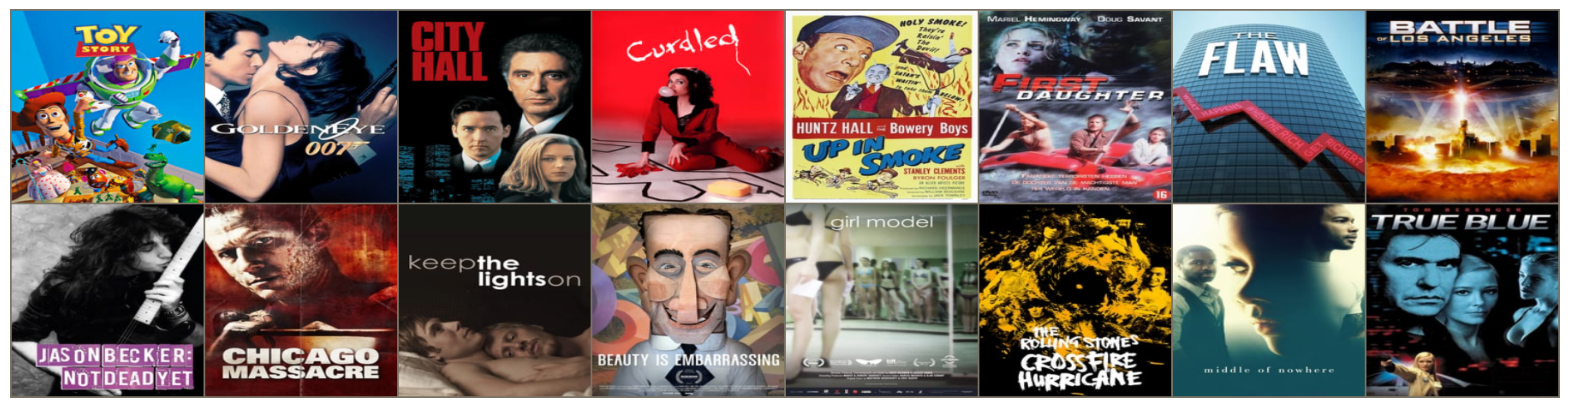

In [57]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
x, paths = next(iter(dataloader))
img_grid = make_grid(x[:16])
img_grid = inv_normalize(img_grid)
plt.figure(figsize=(20,15))
plt.imshow(img_grid.permute(1, 2, 0))
plt.axis('off')

Instantiate a pre-trained a mobilenet_v3_small model (documentation [here](https://pytorch.org/vision/stable/models.html))

In [8]:
import torchvision.models as models
mobilenet = models.mobilenet_v3_small(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 131MB/s]


Have a look to the model:

In [9]:
mobilenet

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

We will now crate a subset of this model to extract the features.
Use a Sequential model to get only the features followed by the avgpool layer of mobilnet and finish with a Flatten layer (```torch.nn.Flatten()```)


In [10]:
model = torch.nn.Sequential(mobilenet.features, mobilenet.avgpool, torch.nn.Flatten()).cuda()

If your model is OK, it should predict 576-dimensional vectors.

In [11]:
import torch
x = torch.zeros(100, 3, 224,224).cuda()
y = model(x)
y.shape

torch.Size([100, 576])

In [61]:
x, _ = next(iter(dataloader))
x[16]

tensor([[[0.2111, 0.2624, 0.3309,  ..., 0.9817, 1.0159, 1.0844],
         [0.3138, 0.3481, 0.4166,  ..., 1.2214, 1.2899, 1.4098],
         [0.5022, 0.5364, 0.5878,  ..., 1.3070, 1.3584, 1.4612],
         ...,
         [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2489, 2.2318],
         [2.2318, 2.2318, 2.2318,  ..., 2.2489, 2.2318, 2.2147],
         [2.2318, 2.2318, 2.2318,  ..., 2.2318, 2.2318, 2.2147]],

        [[0.6254, 0.6779, 0.7479,  ..., 1.4307, 1.4482, 1.4832],
         [0.7129, 0.7479, 0.8179,  ..., 1.6758, 1.7458, 1.8333],
         [0.8704, 0.9055, 0.9580,  ..., 1.7808, 1.8508, 1.9034],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4111],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4111, 2.3936],
         [2.4286, 2.4286, 2.4286,  ..., 2.4111, 2.4111, 2.3936]],

        [[1.7337, 1.7860, 1.8557,  ..., 2.4308, 2.4308, 2.4483],
         [1.8383, 1.8731, 1.9428,  ..., 2.6051, 2.6226, 2.6400],
         [2.0125, 2.0474, 2.0997,  ..., 2.5877, 2.6226, 2.

We will now create a dataframe with our extracted features and the path to the poster image.

In [12]:
import pandas as pd
from tqdm.notebook import tqdm

features_list = []
paths_list = []

for x, paths in tqdm(dataloader):
    with torch.no_grad():
        embeddings = model(x.cuda())
        features_list.extend(embeddings.cpu().numpy())
        paths_list.extend(paths)

df = pd.DataFrame({
    'features': features_list,
    'path': paths_list
})

df.head()

  0%|          | 0/211 [00:00<?, ?it/s]

features  \
0  [0.80964106, 0.24100164, 0.37724042, 0.2433506...   
1  [0.3985363, 1.1435978, 0.61153394, 0.30507118,...   
2  [0.30924165, -0.0037492733, -0.024863299, 0.42...   
3  [0.10391185, 0.42122585, 0.66152906, 0.0102558...   
4  [0.38010776, -0.02901392, 0.25245747, 0.431327...   

                         path  
0       MLP-20M/MLP-20M/1.jpg  
1      MLP-20M/MLP-20M/10.jpg  
2     MLP-20M/MLP-20M/100.jpg  
3    MLP-20M/MLP-20M/1000.jpg  
4  MLP-20M/MLP-20M/100003.jpg

We will now extract all the features into a numpy array that will be used to compute the similarity matrix.

In [13]:
import numpy as np
features = np.vstack(features_list)
features.shape

(26938, 576)

Now compute the cosine similarity between the embeddings of your movies.

In [14]:
from sklearn.metrics.pairwise import cosine_distances
cosine_sim = cosine_distances(features, features)
cosine_sim.shape

(26938, 26938)

The ```plot_image``` function  will display a poster according to it's path.
Fill the ```plot_images``` function to plot a series of posters from a list of paths

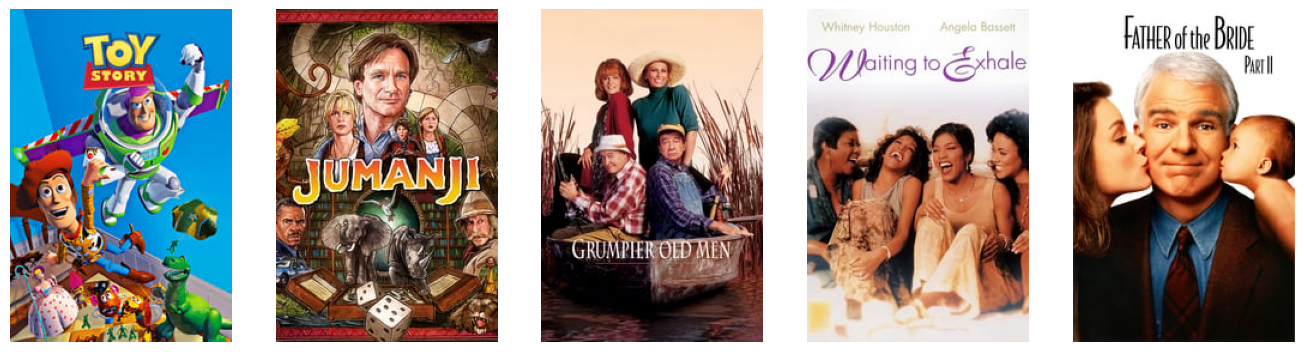

In [15]:
import matplotlib.image as mpimg

def plot_image(path):
  img = mpimg.imread(path)
  plt.imshow(img)
  plt.axis('off')

def plot_images(paths_list):
  plt.figure(figsize=(20,20))
  n = len(paths_list)
  for i, path in enumerate(paths_list):
    plt.subplot(1, n+1, i+1)
    plot_image(path)


plot_images(['MLP-20M/MLP-20M/1.jpg', 'MLP-20M/MLP-20M/2.jpg', 'MLP-20M/MLP-20M/3.jpg', 'MLP-20M/MLP-20M/4.jpg', 'MLP-20M/MLP-20M/5.jpg'])

Fill the following code to implement a function that plots the top 5 recommendations for a movie according to its index.

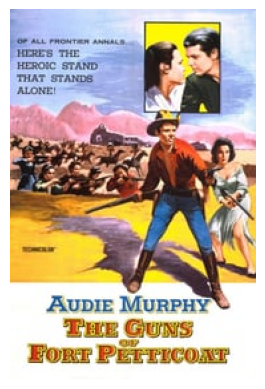

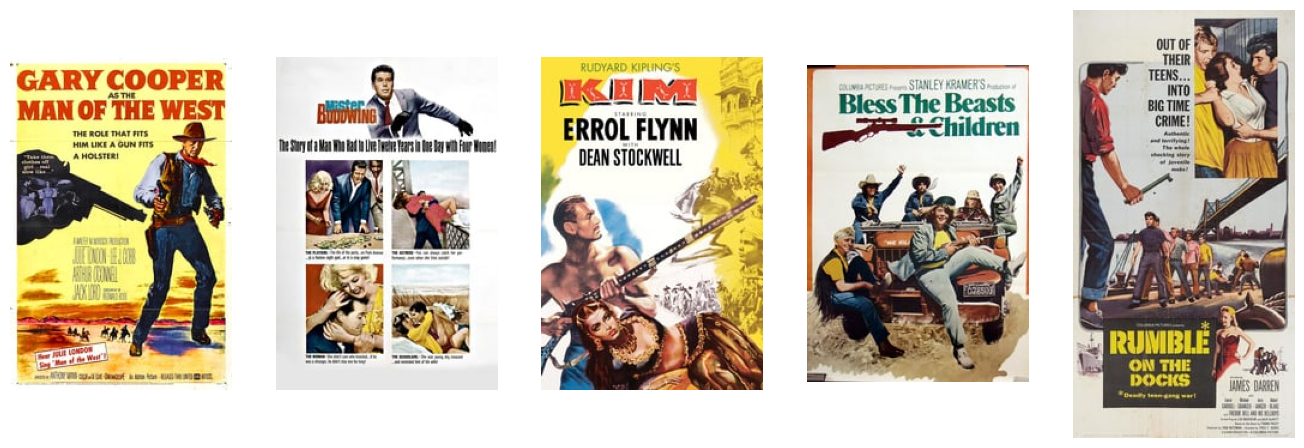

In [16]:
def plot_reco(idx, sim_matrix):
  img = plot_image(df['path'][idx])
  recos = sim_matrix[idx].argsort()[1:6]
  reco_posters = df.iloc[recos]['path'].tolist()
  plot_images(reco_posters)

idx = 16 #10 #200
plot_reco(idx, cosine_sim)

Try with different movie indexes, you will be surprised by the lack of originality of the poster designers!  
Look at [this post](https://thechive.com/2020/01/20/all-movie-posters-look-the-same-what-the-hell-is-this-sht-20-photos/) to convince yourself.

## Vector databases  

Computing the similarity matrix is a very expensive operation in terms of memory and computation time that scales quadratically with the number of items.  It is also not very practical to store this matrix in a database.  
Vector databases offer a suite of advantages tailored to the needs of modern data analytics and machine learning applications. At their core, they specialize in handling high-dimensional data, allowing for efficient similarity searches—something traditional databases struggle with. This makes them invaluable for tasks like recommendation systems, image searches, and semantic text retrieval. Beyond search efficiency, vector databases are designed for scalability, capable of handling billions of vectors without a hitch. Furthermore, they often come with built-in mechanisms for distributed storage and computation, ensuring data resilience and fast query speeds even as data volumes grow. In essence, vector databases are the backbone that empowers many of the AI-driven solutions we see today.  
For our current session, we're aiming for simplicity and efficiency. Many of the standard vector databases, like [Milvus](https://milvus.io/) or [Weaviate](https://weaviate.io/), require their own dedicated installations and often need to run on separate servers or containers.  
This can introduce added complexity. Instead, we're turning to [Annoy](https://github.com/spotify/annoy) a straightforward library developped by Spotify that lets us perform efficient neighbor searches without the installation and server overhead. While Annoy is great for our present needs, do keep in mind that in larger, production scenarios, the capabilities of a dedicated vector database could be invaluable.

In [17]:
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552447 sha256=c4b5ec942f1be0bb848835f2a413a2a1827264b2f6d6a7a88a416d1c6969b027
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


We will thus use the annoy library to create a vector database with our features.  
In our case the database will be a simple file on the disk that we will load in memory when needed.
To create the database, we will use an AnnoyIndex with the same dimensionality as our features and a metric to compute the distance between vectors.  
Here we will use the cosine distance and set the database vector size to 576 (the size of our features).

In [34]:
from annoy import AnnoyIndex

dim = 576
annoy_index = AnnoyIndex(dim, 'angular')

We will now fill the database with our features as indexed vectors.

In [36]:
for i, embedding in enumerate(features_list):
    annoy_index.add_item(i, embedding)

annoy_index.build(10)

True

The `annoy_index.build(10)` command builds the underlying data structures required for Annoy to perform its approximate nearest neighbor searches. Specifically, the number 10 indicates that Annoy should construct 10 trees. Building multiple trees helps improve the accuracy of the search at the expense of using more memory. In essence, this command is preparing Annoy to efficiently handle future queries.

Vector databases excel at efficient similarity searches due to their foundational design principles. Traditional databases rely on exact matches or predefined indices to retrieve data. In contrast, vector databases operate in the realm of high-dimensional vector spaces. Here, data points (or vectors) that are semantically or contextually similar are often closer in distance. By leveraging algorithms optimized for these spaces, like approximate nearest neighbor (ANN) searches, vector databases quickly identify data points that lie near a query point. This spatial awareness enables them to bypass exhaustive scans and zero in on relevant results, making similarity searches both rapid and precise.
Thus querying the database for the most similar items to a given item is a very fast operation.  
Complete the following function to retrieve the most similar items to a given item.

In [20]:
def search(query_vector, k=5):
    indices = annoy_index.get_nns_by_vector(query_vector, k)
    paths = [paths_list[idx] for idx in indices]
    return paths

Use this function to plot the top-k recommendations for a movie.

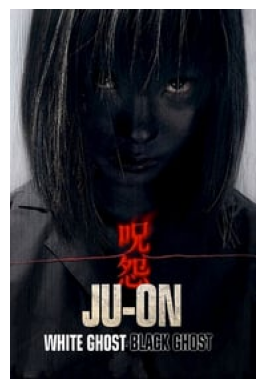

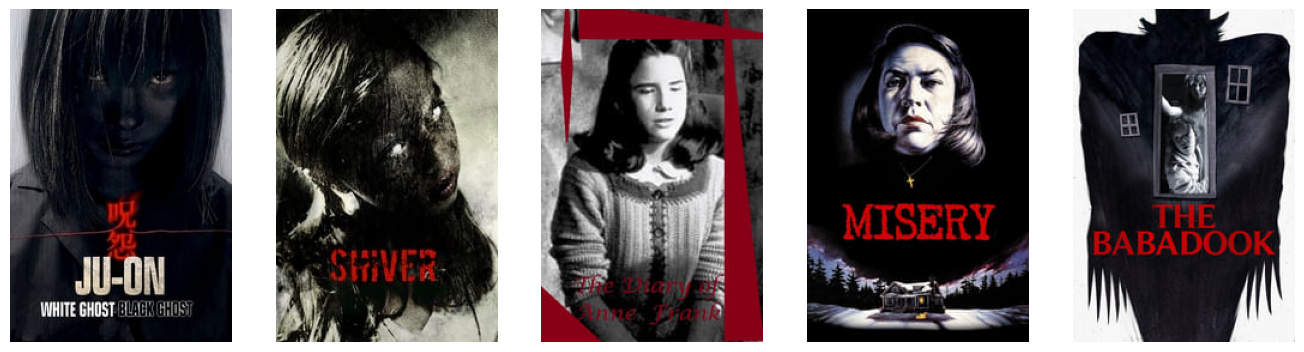

In [21]:
index = 600
plot_image(df.path[index])
query_vector = df.features[index]
result = search(query_vector)
plot_images(result)

In [22]:
annoy_index.save('rec_imdb.ann')

True

In [23]:
pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.5 MB/s eta 0:

In [54]:
import torch
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small
from annoy import AnnoyIndex
from PIL import Image
import gradio as gr

mobilenet = mobilenet_v3_small(pretrained=True)
model = torch.nn.Sequential(mobilenet.features, mobilenet.avgpool, torch.nn.Flatten()).cuda()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


f = 576
index = AnnoyIndex(f, 'angular')
index.load('rec_imdb.ann')

def image_to_vector(image):
    # image = Image.fromarray(input_image_np.astype('uint8'))
    image_tensor = transform(image).unsqueeze(0).cuda()
    print(image_tensor)
    vector = model(image_tensor)
    return vector.detach().cpu().numpy()[0]

def create_collage(images, width=224, height=224):
    size = (width, height)
    collage = Image.new('RGB', (width * 5, height))
    for index, image in enumerate(images):
        image.thumbnail(size)
        collage.paste(image, (index * width, 0))
    return collage

def find_similar_images(input_image):
    vector = image_to_vector(input_image)
    nearest_indices = index.get_nns_by_vector(vector, 5)
    paths = [paths_list[idx] for idx in nearest_indices]
    # paths = [index.get_item_vector(i) for i in nearest_indices]
    print(paths)
    images = [Image.open(path) for path in paths]
    collage = create_collage(images)
    return collage

interface = gr.Interface(
    fn=find_similar_images,
    inputs=gr.Image(type="pil"),
    outputs="image"
)

interface.launch(debug=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2

# Collaborative filtering

### Item-Item

Item-item collaborative filtering, is a form of collaborative filtering for recommender systems based on the similarity between items calculated using people's ratings.
For sake of simplicity, in this practical session, we will only focus on item-item similarity methods.
If you have time, feel free to try an user-item approach. The following [blog post](https://notebook.community/saksham/recommender-systems/Collaborative%20Filtering) may help you to do it.

We will use another dataset containing the ratings of several users on movies.

In [ ]:
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
!wget https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv

--2023-08-25 21:57:33--  https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/movies.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494431 (483K) [text/plain]
Saving to: ‘movies.csv’

movies.csv          100%[===================>] 482.84K  --.-KB/s    in 0.03s   

2023-08-25 21:57:34 (18.6 MB/s) - ‘movies.csv’ saved [494431/494431]

--2023-08-25 21:57:34--  https://raw.githubusercontent.com/wikistat/AI-Frameworks/master/RecomendationSystem/movielens_small/ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, 

In [ ]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.rename(columns={'movieId':'id'})
ratings['id'] = pd.to_numeric(ratings['id'])
ratings = pd.merge(ratings, metadata[['title', 'id']], on='id')[['userId', 'id', 'rating', 'title']]
ratings.head()

userId     id  rating                                 title
0       1  58559     4.0  Confession of a Child of the Century
1       7  58559     5.0  Confession of a Child of the Century
2      11  58559     4.5  Confession of a Child of the Century
3      15  58559     5.0  Confession of a Child of the Century
4      20  58559     5.0  Confession of a Child of the Century

In [ ]:
ratings.shape

(220899, 4)

This dataset is a bit huge and may slow down futur computations. Moreover collaborative filtering kind of suffers from products or user with few ratings.
We will only focus on the 100 movies with the most ratings and the users with the highest number of ratings.

In [ ]:
# filter movies
ratings['count'] = ratings.groupby('id').transform('count')['userId']
movieId = ratings.drop_duplicates('id').sort_values(
    'count', ascending=False).iloc[:200]['id']
ratings = ratings[ratings['id'].isin(movieId)].reset_index(drop=True)

#filter users
ratings['count'] = ratings.groupby('userId').transform('count')['id']
userId = ratings.drop_duplicates('userId').sort_values(
    'count', ascending=False).iloc[:20001]['userId']
ratings = ratings[ratings['userId'].isin(userId)].reset_index(drop=True)

ratings.shape

(163182, 5)

In [ ]:
ratings.head()

In [ ]:
ratings.title.unique()[:100]

array(['Confession of a Child of the Century', 'Caesar Must Die',
       'The Woman with the 5 Elephants', 'The Tortured', 'Gravity',
       'In Time', '5 Days of War', 'Horrible Bosses',
       'Mega Python vs. Gatoroid', 'Qualunquemente', 'Cat Run', 'Brake',
       'Bertsolari', 'Tomorrow, When the War Began', 'Needle',
       'Heart of the Country', 'Mere Brother Ki Dulhan', 'Rio Sex Comedy',
       'Captain America: The First Avenger', 'EVA', 'Blind Man',
       'At Risk', 'Stitches', 'One in the Chamber', 'Foodfight!',
       'Bridesmaids', 'Cars 2', 'A BIG Love Story',
       'Bill Burr: Let It Go', 'The Prey', 'Arena', 'War of the Buttons',
       'Contraband', 'The Watermen', 'Memory Lane',
       'The Fantastic Flying Books of Mr Morris Lessmore', 'This Is 40',
       'Fanatics', 'Looking for Lenny', 'Posti in piedi in paradiso',
       'Austin High', 'Stolen Seas', 'Cockpit',
       'Space Chimps 2: Zartog Strikes Back', 'Five Dances',
       'War of the Arrows', 'Rise of the

In [ ]:
movie_vector = pivot["Moonrise Kingdom"]
similarity = pivot.corrwith(movie_vector)
similarity = similarity.sort_values(ascending=False)
similarity.head(10)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


title
The Prospects                         1.0
Captain America: The First Avenger    1.0
Repeaters                             1.0
Posti in piedi in paradiso            1.0
One in the Chamber                    1.0
Moonrise Kingdom                      1.0
Looking for Lenny                     1.0
The First Grader                      1.0
The Runway                            1.0
Attack of the 50 Foot Cheerleader     1.0
dtype: float64

Now, we need to build a pivot table with user in lines, movies in columns and ratings as values.
Use pandas [pivot_table](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html) method to create this pivot table.

In [ ]:
pivot = ratings.pivot_table(index = ["userId"],columns = ["title"],values = "rating")
pivot.head(100)

title   !Women Art Revolution  (A)Sexual  12 Dates of Christmas  \
userId                                                            
11                        NaN        NaN                    NaN   
15                        NaN        NaN                    NaN   
28                        NaN        NaN                    NaN   
41                        NaN        NaN                    NaN   
56                        NaN        NaN                    NaN   
...                       ...        ...                    ...   
1072                      NaN        NaN                    NaN   
1073                      NaN        NaN                    NaN   
1104                      NaN        NaN                    NaN   
1113                      NaN        NaN                    NaN   
1114                      NaN        NaN                    NaN   

title   12 Wishes of Christmas  127 Hours  13 Sins  17 Girls  30 Beats  \
userId                                                                   
11                         NaN        NaN      NaN       NaN       NaN   
15                         NaN        NaN      NaN       NaN       NaN   
28                         NaN        NaN      NaN       NaN       NaN   
41                         NaN        NaN      NaN       NaN       NaN   
56                         NaN        NaN      NaN       NaN       NaN   
...                        ...        ...      ...       ...       ...   
1072                       NaN        NaN      NaN       NaN       NaN   
1073                       NaN        NaN      NaN       NaN       NaN   
1104                       NaN        NaN      NaN       NaN       NaN   
1113                       NaN        NaN      NaN       NaN       NaN   
1114                       NaN        NaN      NaN       NaN       NaN   

title   30 Minutes or Less  3nity  ...  You Are God  \
userId                             ...                
11                     NaN    NaN  ...          NaN   
15                     NaN    NaN  ...          NaN   
28                     NaN    NaN  ...          NaN   
41                     NaN    NaN  ...          NaN   
56                     NaN    NaN  ...          NaN   
...                    ...    ...  ...          ...   
1072                   NaN    NaN  ...          NaN   
1073                   NaN    NaN  ...          NaN   
1104                   NaN    NaN  ...          NaN   
1113                   NaN    NaN  ...          NaN   
1114                   NaN    NaN  ...          NaN   

title   You Are the Apple of My Eye  You Instead  Youth  \
userId                                                    
11                              NaN          NaN    NaN   
15                              NaN          NaN    NaN   
28                              NaN          NaN    NaN   
41                              NaN          NaN    NaN   
56                              NaN          NaN    NaN   
...                             ...          ...    ...   
1072                            NaN          NaN    NaN   
1073                            NaN          NaN    NaN   
1104                            NaN          3.5    NaN   
1113                            NaN          NaN    NaN   
1114                            NaN          NaN    NaN   

title   Yu-Gi-Oh! 3D: Bonds Beyond Time  Yuddham Sei  Zero Charisma  Zhit  \
userId                                                                      
11                                  NaN          NaN            NaN   NaN   
15                                  NaN          NaN            NaN   NaN   
28                                  NaN          NaN            NaN   NaN   
41                                  NaN          NaN            NaN   NaN   
56                                  NaN          NaN            NaN   NaN   
...                                 ...          ...            ...   ...   
1072                                NaN          NaN            N

With this pivot table, it is now easy to compute the similarity between movies.
Indeed each movie can be represented by a vector of the users' ratings.
Instead of using a cosine similarity distance as we did earlier in the notebook, we will use the Pearson correlation score since it is already implemented in Pandas.
The pivot table has a method ```corrwith``` that will return the Pairwise correlation score of one entry with all entries of the table.

In [ ]:
movie_vector = pivot["Rambo III"]
similarity = pivot.corrwith(movie_vector)
similarity.head()

title
20,000 Leagues Under the Sea    0.363313
2001: A Space Odyssey           0.261591
48 Hrs.                         0.269533
5 Card Stud                     0.159400
A Brief History of Time         0.120379
dtype: float64

Sort the produced results to get the best recommendations to The Bourne Supremacy.
You may also try with different movies.

In [ ]:
similarity = similarity.sort_values(ascending=False)
similarity.head(10)

title
Rambo III                     1.000000
Back to the Future Part II    0.600266
We Own the Night              0.557096
Aguirre: The Wrath of God     0.480179
Parenthood                    0.459118
Tough Enough                  0.447605
When Saturday Comes           0.441732
Almost Famous                 0.433944
Armageddon                    0.419988
A Nightmare on Elm Street     0.413315
dtype: float64

## Matrix factorization
Matrix factorization is certainly one of the most efficient way to build a recomender system. I really encourage you to have a look to [this article](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf) presenting the matrix factorization techniques used in recommender systems.

The idea is pretty simple, it consists in factorizing the ratings matrix $R$ into the product of a user embedding matrix $U$ and an item embedding matrix $V$, such that $R \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Where
- $N$ is the number of users,
- $M$ is the number of items,
- $R_{ij}$ is the rating of the $j$th item by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing item $j$,


One these emmbeding matrices are built, predicting the rating of an user $i$ for an item $j$ consists in computing the dot product $\langle U_i, V_j \rangle$.

### Using surpise

![](https://drive.google.com/uc?export=view&id=1dh2RJ95F0j-rZyuf59G35239B42veAWD)

We will begin by using the famous Singular Value Decomposition method.
Several libraries implement this algorithm.
In this session, we will be using [Surprise](http://surpriselib.com/).
Surprise is a recommender system library implemented in Python.
It was actually developed by [Nicolas Hug](http://nicolas-hug.com/about) an INSA Toulouse Alumni!

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095436 sha256=eac9eeb0ce0dc5eb1e0feaa3c241233ac1bc24156326fc7de88e74c882120377
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


Surprise implements the SVD algorithm.  Help yourself with [the doc](https://surprise.readthedocs.io/en/stable/getting_started.html) to train an SVD model on the rating dataset.

In [ ]:
#Creating a train and a test set
testset = ratings.sample(frac=0.1, replace=False)
trainset = ratings[~ratings.index.isin(testset.index)]

assert set(testset.userId.unique()).issubset(trainset.userId.unique())
assert set(testset.id.unique()).issubset(trainset.id.unique())

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [ ]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'id', 'rating']].fillna(0), reader)
svd = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7581  0.7583  0.7587  0.7608  0.7592  0.7590  0.0010  
MAE (testset)     0.5769  0.5775  0.5782  0.5791  0.5783  0.5780  0.0007  
Fit time          29.95   15.63   16.39   16.07   18.62   19.33   5.41    
Test time         3.24    2.60    2.44    2.96    2.79    2.81    0.28    


{'test_rmse': array([0.75806051, 0.75828463, 0.75869864, 0.76083426, 0.75922678]),
 'test_mae': array([0.57694309, 0.57753463, 0.57816418, 0.57909961, 0.57831574]),
 'fit_time': (29.94826912879944,
  15.630887269973755,
  16.388001441955566,
  16.066394090652466,
  18.62168574333191),
 'test_time': (3.239062547683716,
  2.6031150817871094,
  2.4438531398773193,
  2.9568254947662354,
  2.7899811267852783)}

In [ ]:
#full dataset training
svd = SVD()
s_trainset = data.build_full_trainset()
svd.fit(s_trainset)

Let us look some ratings for one user in the test dataset.

In [ ]:
testset[testset['userId'] == 24]

userId    id  rating                                 title  count
1016508      24   454     3.0                        Romeo + Juliet     57
857285       24  1387     4.0  Superstar: The Karen Carpenter Story     57
351425       24   293     4.0               A River Runs Through It     57
811392       24  1610     4.0                           Fever Pitch     57
1010074      24    62     2.0                 2001: A Space Odyssey     57

What would your model predict for these exemples?

In [ ]:
uid = 24
iid = 3114

svd.predict(uid, iid)

Prediction(uid=24, iid=3114, r_ui=None, est=3.926560852804574, details={'was_impossible': False})

Write a code to recommend 5 movies to an user.

### Using gradient descent
Another way to compute the matrix factorization consists in using gradient descent to minimize $\text{MSE}(R, UV^\top)$ where:

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( R_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.

We will now implement our own matrix factorization algorith using Pytorch.
To do so we first need to convert our ratings datasets in Pytorch datasets.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

user_list = trainset.userId.unique()
item_list = trainset.id.unique()
user2id = {w: i for i, w in enumerate(user_list)}
item2id = {w: i for i, w in enumerate(item_list)}

class Ratings_Datset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = user2id[self.df['userId'][idx]]
        user = torch.tensor(user, dtype=torch.long)
        item = item2id[self.df['id'][idx]]
        item = torch.tensor(item, dtype=torch.long)
        rating = torch.tensor(self.df['rating'][idx], dtype=torch.float)
        return user, item, rating


trainloader = DataLoader(Ratings_Datset(trainset), batch_size=512, shuffle=True ,num_workers=2)
testloader = DataLoader(Ratings_Datset(testset), batch_size=64, num_workers=2)

These dataloader will provide mini-batches of tuples <user, movie, rating>.
We will use a special type of Pytorch layers call [Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
These layers will create a mapping between an index and a vector representation.
In our case they will provide vector representations of our users and items.
We will train the matrix factorization model to minimize the prediction error between a rating and the dot product of an user embedding with a movie embedding.
![](https://drive.google.com/uc?export=view&id=1wSQbcSN_I28mF74-wnb8_qjAzRH9YDjA)

Complete the following code to implement the ```MatrixFactorization``` class in Pytorch.

In [ ]:
import torch

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        return torch.mul(self.user_embeddings(user), self.item_embeddings(item)).sum(1)
        #return (self.user_embeddings(user)*self.item_embeddings(item)).sum(1)

Complete the training method that we will use to train the network.

In [ ]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from statistics import mean


def train(model, optimizer, trainloader, epochs=30):
    criterion = nn.MSELoss(reduction='mean')
    t = tqdm(range(epochs))
    for epoch in t:
        corrects = 0
        total = 0
        train_loss = []
        for users, items, r in trainloader:
            users = users.cuda()
            items = items.cuda()
            r = r.cuda() / 5
            y_hat = model(users, items)
            loss = criterion(y_hat, r.unsqueeze(1).float())
            train_loss.append(loss.item())
            total += r.size(0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            t.set_description(f"loss: {mean(train_loss)}")

We now have everything to train our model.
Train your model for 5 to 10 epochs.

In [ ]:
n_user = trainset.userId.nunique()
n_items = trainset.id.nunique()
model = MatrixFactorization(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([512, 1])) that is different to the input size (torch.Size([512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([376, 1])) that is different to the input size (torch.Size([376])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Complete the following code to evaluate your model.

In [ ]:
import math

def test(model, testloader, m_eval=False):


    running_mae = 0
    with torch.no_grad():
        corrects = 0
        total = 0
        for users, items, r in testloader:
            users = users.cuda()
            items = items.cuda()
            y = r.cuda() / 5
            y_hat = model(users, items).flatten()
            error = torch.abs(y_hat - y).sum().data

            running_mae += error
            total += y.size(0)

    mae = running_mae/total
    return mae * 5


test(model, testloader)

tensor(1.4411, device='cuda:0')

Try to compare the predictions of your model with actual ratings.

In [ ]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([2.5000, 4.0000, 4.0000, 4.5000, 4.0000, 3.0000, 4.5000, 5.0000, 5.0000,
        2.5000], device='cuda:0')
predictions: tensor([ 2.4959,  4.0959,  4.3286,  2.8543,  4.2017,  4.3369, -0.1493,  2.8040,
         1.7782,  3.7293], device='cuda:0')


We just trained a matrix factorization algorithm using Pytorch.
In this setting, the final prediction was made with the dot product of our embeddings.
Actually with a minimal modification of the Class, we could create a full neural network.
If we replace the dot product with a fully-connected network, we would actually have an end-to-end neural network able to predict the ratings of our users.
![](https://drive.google.com/uc?export=view&id=1THBMB-Z3db0Rn0dyYYWhN98AHcYEM-nT)
This approach is called Neural Collaborative Filtering and is presented in this [paper](https://arxiv.org/pdf/1708.05031.pdf).
Try to fill in the following code to create an NCF network.



In [ ]:
class NCF(nn.Module):

    def __init__(self, n_users, n_items, n_factors=8):
        super().__init__()
        self.user_embeddings = torch.nn.Embedding(n_users, n_factors)
        self.item_embeddings = torch.nn.Embedding(n_items, n_factors)
        self.predictor = torch.nn.Sequential(
            nn.Linear(in_features=n_factors*2, out_features=64),
            nn.Linear(in_features=64, out_features=32),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )


    def forward(self, user, item):


        u = self.user_embeddings(user)
        i = self.item_embeddings(item)

        # Concat the two embedding layers
        z = torch.cat([u, i], dim=-1)
        return self.predictor(z)

Train your NCF network on the train dataset and test it on the test dataset.

In [ ]:
model = NCF(n_user, n_items).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, optimizer, trainloader, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
test(model, testloader)

tensor(0.6200, device='cuda:0')

In [ ]:
users, movies, r = next(iter(testloader))
users = users.cuda()
movies = movies.cuda()
r = r.cuda()

y = model(users, movies)*5
print("ratings", r[:10].data)
print("predictions:", y.flatten()[:10].data)

ratings tensor([2.5000, 4.0000, 4.0000, 4.5000, 4.0000, 3.0000, 4.5000, 5.0000, 5.0000,
        2.5000], device='cuda:0')
predictions: tensor([2.9032, 3.9094, 4.1405, 3.8615, 3.5506, 3.6759, 4.0751, 4.3432, 4.0610,
        3.5029], device='cuda:0')


### Implicit feedback with pytorch

In this practical session, we only worked with explicit feedbacks (ratings).
Sometimes you do not have access to such quantitative feedback and have to deal with implicit feedback.
An implicit feedback is a user's qualitative interaction with an item, such as clicking on an item (positive feedback) or stopping watching a video (negative feedback).
If you are interested in neural collaborative filtering in the case of implicit feedback, I recommend you look at this [excellent tutorial](https://sparsh-ai.github.io/rec-tutorials/matrixfactorization%20movielens%20pytorch%20scratch/2021/04/21/rec-algo-ncf-pytorch-pyy0715.html).